In [1]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# If you don't have lifelines yet, run this once in a separate cell:
# !pip install lifelines

from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test


In [7]:
# ---- LOAD RAW ----
df_raw = pd.read_csv(TCGA_EXPR, sep="\t", low_memory=False)
print("Raw shape:", df_raw.shape)
print("Column preview:", list(df_raw.columns[:10]))

# ---- 1. Identify gene column automatically ----
gene_col = None
for c in df_raw.columns:
    c_lower = c.lower()
    if ("gene" in c_lower) or ("hybridization" in c_lower) or ("id" == c_lower):
        gene_col = c
        break

if gene_col is None:
    raise ValueError("❗ Could not detect gene column — inspect df_raw.columns manually.")

print("Detected gene column:", gene_col)

# ---- 2. Extract gene symbols safely ----
# If "GENE|1234" → keep "GENE"
df_raw["gene_symbol"] = (
    df_raw[gene_col]
    .astype(str)
    .str.split("|", n=1)
    .str[0]
)

# ---- 3. Identify all numeric sample columns explicitly ----
numeric_cols = []
for col in df_raw.columns:
    if col == gene_col or col == "gene_symbol":
        continue
    # try converting first 5 values to numeric
    sample = pd.to_numeric(df_raw[col].head(5), errors="coerce")
    if sample.notna().sum() >= 3:   # majority numeric
        numeric_cols.append(col)

print(f"Detected {len(numeric_cols)} numeric expression columns.")

# ---- 4. Build a clean gene × sample matrix ----
df_expr = df_raw[["gene_symbol"] + numeric_cols].copy()
df_expr = df_expr.set_index("gene_symbol")

# Convert all values to numeric (safest)
df_expr = df_expr.apply(pd.to_numeric, errors="coerce")

# ---- 5. Collapse duplicate gene symbols safely ----
df_expr = df_expr.groupby(df_expr.index).mean()

# ---- 6. Drop weird gene names only if they exist ----
for bad in ["?", "NA", "na", "", None]:
    if bad in df_expr.index:
        df_expr = df_expr.drop(index=bad, errors="ignore")

print("Final cleaned expression matrix:", df_expr.shape)
display(df_expr.head())


Raw shape: (20532, 184)
Column preview: ['Hybridization REF', 'TCGA-2J-AAB1-01A-11R-A41B-07', 'TCGA-2J-AAB4-01A-12R-A41B-07', 'TCGA-2J-AAB6-01A-11R-A41B-07', 'TCGA-2J-AAB8-01A-12R-A41B-07', 'TCGA-2J-AAB9-01A-11R-A41B-07', 'TCGA-2J-AABA-01A-21R-A41B-07', 'TCGA-2J-AABE-01A-12R-A41B-07', 'TCGA-2J-AABF-01A-31R-A41B-07', 'TCGA-2J-AABH-01A-21R-A41B-07']
Detected gene column: Hybridization REF
Detected 183 numeric expression columns.
Final cleaned expression matrix: (20502, 183)


,TCGA-2J-AAB1-01A-11R-A41B-07,TCGA-2J-AAB4-01A-12R-A41B-07,TCGA-2J-AAB6-01A-11R-A41B-07,TCGA-2J-AAB8-01A-12R-A41B-07,TCGA-2J-AAB9-01A-11R-A41B-07,TCGA-2J-AABA-01A-21R-A41B-07,TCGA-2J-AABE-01A-12R-A41B-07,TCGA-2J-AABF-01A-31R-A41B-07,TCGA-2J-AABH-01A-21R-A41B-07,TCGA-2J-AABI-01A-12R-A41B-07,...,TCGA-XD-AAUH-01A-42R-A41B-07,TCGA-XD-AAUI-01A-42R-A41B-07,TCGA-XD-AAUL-01A-21R-A39D-07,TCGA-XN-A8T3-01A-11R-A36G-07,TCGA-XN-A8T5-01A-12R-A36G-07,TCGA-YB-A89D-11A-11R-A36G-07,TCGA-YB-A89D-01A-12R-A36G-07,TCGA-YH-A8SY-01A-11R-A37L-07,TCGA-YY-A8LH-01A-11R-A36G-07,TCGA-Z5-AAPL-01A-12R-A41B-07
gene_symbol,,,,,,,,,,,,,,,,,,,,,
A1BG,81.9122,56.7551,82.5497,56.9307,105.7878,99.3455,79.4019,92.7368,52.5740,76.3316,...,135.0495,141.4958,101.9751,132.0253,122.8427,140.5795,156.8859,239.3867,65.8274,120.8775
A1CF,25.3659,53.4512,8.1871,33.8425,21.4362,18.7882,3.0831,112.3416,62.2822,0.0000,...,42.6861,85.6860,89.3971,21.0970,9.5352,12.3824,73.9979,2.3364,29.9857,3.9886
A2BP1,0.4878,2.1044,0.0000,0.0000,1.0718,0.0000,0.0000,3.1895,1.3066,0.3628,...,10.9318,2.4765,0.8316,0.0000,4.1716,3.9624,1.0277,0.0000,3.9687,0.0000
A2LD1,180.4976,111.0774,163.1228,185.8143,166.7095,99.2767,134.5645,112.9760,261.8772,56.9993,...,88.4279,158.4200,67.4304,104.5200,89.0226,103.3779,104.0904,87.4533,120.9525,106.7749
A2M,19703.8049,15837.8241,8517.4444,14413.9130,24311.7792,10302.0072,11076.8614,18795.9458,14776.9425,3769.4702,...,23815.5128,20787.3452,22677.6549,18811.5876,20203.6412,31255.4185,23524.5683,8438.5456,4471.2821,10193.6752


In [9]:
# Your module genes (from your message)
IGE_UP = [
"PFN2","SET","LGALS1","PDLIM4","EIF5A","F8A1","BANF1","CTDNEP1","TRAPPC1","AMZ2","PTGES3","ST13","FTH1","PCBP1",
"NAA10","ARPC5L","ETFB","CCDC124","SSR2","PGLS","SELENOH","GSTP1","NDUFB7","AURKAIP1","GCHFR","MYL6","AP2S1",
"S100A13","C9orf16","KRT8","PRKCSH","CST3","PET100","DNAJA2","VPS35","VDAC1","MGST3","PRR13","OCIAD2","FUOM","MIA",
"RPN1","FUCA2","TMED4","ERGIC3","DDOST","NAXE","SNRPD1","SKP1","CNBP","ATP5MC3","SLC25A5","LSM4","NDUFAB1","PCBD1",
"HINT1","ADI1","NENF","MRPL43","VKORC1","EMC4","COA3","NEDD8","CHCHD2","PRDX5","WDR83OS","NDUFA4","GABARAP","PHPT1",
"UFC1","MDH1","ATP5F1E","MRPL41","UBL5","COX5B","ELOB","ATP5ME","UQCRB","SEM1","NDUFB1","COX6C","ATP6V1F","HNRNPA1",
"HIGD2A","POLR2I","METTL26","NDUFB4","OST4","C19orf53","RPL36AL","PPIA","COPS9","COX8A","COX5A","RPL36","RPS15",
"RPS27","RPS11","FTL","SNHG29","NACA","RPS17","RPL23","RPL39","RPS21","RPL9","RPL15","RPL34","RPL27A","RPL36A",
"RPL38","RPS26","RPS14","RPL35","RPL37A","RPL37","RPL12","RPS29"
]
IGE_DOWN = ["STN1","NRG4","IQSEC2","IYD","CHD9","APBB1IP","TMEM238","REX1BD","IFI27","CYBA","METRNL","AKR7A2",
            "SULT1A1","ARHGEF35","AC008397.1","KLK11","DELE1","MISP","FAM234A","CMBL"]

# 

In [12]:
# Cell 3 – prepare expression for scoring + compute IGE signed module score

import numpy as np

def score_signed_module(expr, up_genes, down_genes, min_genes=10):
    """
    expr: gene x sample matrix (rows=genes, cols=samples), numeric
    up_genes / down_genes: lists of gene symbols
    Returns:
      score: pd.Series (index = samples)
      cov:   dict with coverage info
    """
    # z-score per gene across samples
    Z = expr.apply(
        lambda x: (x - x.mean()) / (x.std(ddof=0) + 1e-9),
        axis=1
    )

    up = pd.Index(up_genes).intersection(Z.index)
    dn = pd.Index(down_genes).intersection(Z.index)

    cov = {
        "up_used": int(up.size),
        "up_total": len(up_genes),
        "down_used": int(dn.size),
        "down_total": len(down_genes),
    }

    if up.size < min_genes or dn.size < min_genes:
        return pd.Series(np.nan, index=Z.columns, name="IGE_signed_score"), cov

    score = (Z.loc[up].mean(axis=0) - Z.loc[dn].mean(axis=0))
    score.name = "IGE_signed_score"
    return score, cov


# 1. Coerce everything to numeric, detect & drop pure annotation rows
expr_numeric = df_tcga.apply(pd.to_numeric, errors="coerce")

non_numeric_only = expr_numeric.notna().any(axis=1) == False
dropped_rows = expr_numeric.index[non_numeric_only].tolist()

print(f"Dropping {len(dropped_rows)} completely non-numeric rows (e.g. annotation rows).")
if dropped_rows:
    print("Example of dropped rows:", dropped_rows[:5])

expr_for_scoring = expr_numeric.loc[~non_numeric_only]
print("Expression matrix for scoring:", expr_for_scoring.shape)

# 2. Compute the signed IGE module score
ige_score_tcga, cov = score_signed_module(
    expr=expr_for_scoring,
    up_genes=IGE_UP,
    down_genes=IGE_DOWN,
    min_genes=10,
)

print("IGE module coverage:")
print(f"  up_genes   used / total: {cov['up_used']} / {cov['up_total']}")
print(f"  down_genes used / total: {cov['down_used']} / {cov['down_total']}")

display(ige_score_tcga.describe())


Dropping 1 completely non-numeric rows (e.g. annotation rows).
Example of dropped rows: ['gene_id']
Expression matrix for scoring: (20531, 183)
IGE module coverage:
  up_genes   used / total: 102 / 118
  down_genes used / total: 13 / 20


count    1.830000e+02
mean    -1.164824e-16
std      6.371325e-01
min     -1.433368e+00
25%     -3.562811e-01
50%     -7.976019e-02
75%      2.363727e-01
max      4.496703e+00
Name: IGE_signed_score, dtype: float64

In [16]:
clin_cbio = pd.read_csv(Path.home() / "Desktop" / "paad_tcga_pan_can_atlas_2018_clinical_data.csv", low_memory=False)


In [17]:
# Cell 3 – inspect and clean clinical file for OS

print("Clinical shape:", clin_cbio.shape)
print("First 20 columns:")
print(list(clin_cbio.columns[:20]))

# --- 3a. Find a sample ID column ---
id_col = None
for c in clin_cbio.columns:
    cl = c.lower()
    if "sample" in cl and "id" in cl:
        id_col = c
        break

if id_col is None:
    for c in clin_cbio.columns:
        cl = c.lower()
        if ("case" in cl or "patient" in cl) and "id" in cl:
            id_col = c
            break

if id_col is None:
    raise ValueError("Couldn't find a sample ID / case ID column – inspect clin_cbio.columns manually.")

# --- 3b. Find OS time + status columns ---
time_col = None
status_col = None
for c in clin_cbio.columns:
    cl = c.lower()
    if time_col is None and "os" in cl and ("month" in cl or "time" in cl or "dur" in cl):
        time_col = c
    if status_col is None and "os" in cl and ("status" in cl or "event" in cl):
        status_col = c

print("\nColumn choices:")
print("  ID column      :", id_col)
print("  OS time column :", time_col)
print("  OS status col  :", status_col)

if time_col is None or status_col is None:
    raise ValueError("Couldn't automatically find OS time/status columns – inspect clin_cbio.columns.")

# --- 3c. Build a clean survival table ---
surv = clin_cbio[[id_col, time_col, status_col]].copy()
surv.rename(
    columns={
        id_col: "sample_id",
        time_col: "os_months",
        status_col: "os_status_raw",
    },
    inplace=True,
)

# Parse OS status into 0/1 event (1 = death)
status = surv["os_status_raw"].astype(str).str.upper()
event = status.str.contains("DECEASED") | status.str.startswith("1")
surv["os_event"] = event.astype(int)

# Force OS time to numeric and drop missing
surv["os_months"] = pd.to_numeric(surv["os_months"], errors="coerce")
surv = surv.dropna(subset=["os_months", "os_event"])

print("\nClean survival table shape:", surv.shape)
display(surv.head())


Clinical shape: (184, 61)
First 20 columns:
['studyId', 'patientId', 'sampleId', 'ANEUPLOIDY_SCORE', 'CANCER_TYPE', 'CANCER_TYPE_DETAILED', 'FRACTION_GENOME_ALTERED', 'GRADE', 'MSI_SCORE_MANTIS', 'MSI_SENSOR_SCORE', 'MUTATION_COUNT', 'ONCOTREE_CODE', 'SAMPLE_TYPE', 'SOMATIC_STATUS', 'TBL_SCORE', 'TISSUE_PROSPECTIVE_COLLECTION_INDICATOR', 'TISSUE_RETROSPECTIVE_COLLECTION_INDICATOR', 'TISSUE_SOURCE_SITE', 'TISSUE_SOURCE_SITE_CODE', 'TMB_NONSYNONYMOUS']

Column choices:
  ID column      : sampleId
  OS time column : OS_MONTHS
  OS status col  : OS_STATUS

Clean survival table shape: (184, 4)


,sample_id,os_months,os_status_raw,os_event
0,TCGA-3A-A9IN-01,68.514318,0:LIVING,0
1,TCGA-2J-AAB4-01,23.966861,0:LIVING,0
2,TCGA-HV-A5A3-01,4.208173,1:DECEASED,1
3,TCGA-FZ-5922-01,36.196864,1:DECEASED,1
4,TCGA-HZ-7925-01,20.186080,1:DECEASED,1


In [19]:
# Cell X – build survival table and merge with IGE scores

import numpy as np
import pandas as pd

# 1. Build clean survival table from the raw clinical dataframe
surv_cols = ["sampleId", "OS_MONTHS", "OS_STATUS"]
missing = [c for c in surv_cols if c not in clin_cbio.columns]
if missing:
    raise ValueError(f"Missing expected clinical columns: {missing}")

clin_surv = clin_cbio[surv_cols].copy()

# rename to simpler / lower-case names
clin_surv = clin_surv.rename(columns={
    "sampleId": "sampleId",
    "OS_MONTHS": "os_months",
    "OS_STATUS": "os_status_raw",
})

# make sure OS time is numeric
clin_surv["os_months"] = pd.to_numeric(clin_surv["os_months"], errors="coerce")

# define event: 1 if status starts with "1:" (DECEASED), else 0
clin_surv["os_event"] = clin_surv["os_status_raw"].astype(str).str.startswith("1:").astype(int)

# drop rows with missing OS time
clin_surv = clin_surv.dropna(subset=["os_months"]).reset_index(drop=True)

print("Clean survival table shape:", clin_surv.shape)
display(clin_surv.head())

# 2. Check that scores_df exists and looks OK
print("\nScore DF preview:")
display(scores_df.head())

# 3. Merge clinical + scores on sampleId
df_km = pd.merge(
    clin_surv[["sampleId", "os_months", "os_event"]],
    scores_df[["sampleId", "IGE_signed_score"]],
    on="sampleId",
    how="inner",
)

print("\nMerged KM-ready table shape:", df_km.shape)
display(df_km.head())


Clean survival table shape: (184, 4)


,sampleId,os_months,os_status_raw,os_event
0,TCGA-3A-A9IN-01,68.514318,0:LIVING,0
1,TCGA-2J-AAB4-01,23.966861,0:LIVING,0
2,TCGA-HV-A5A3-01,4.208173,1:DECEASED,1
3,TCGA-FZ-5922-01,36.196864,1:DECEASED,1
4,TCGA-HZ-7925-01,20.186080,1:DECEASED,1



Score DF preview:


,full_barcode,IGE_signed_score,sampleId
0,TCGA-2J-AAB1-01A-11R-A41B-07,-0.501327,TCGA-2J-AAB1-01
1,TCGA-2J-AAB4-01A-12R-A41B-07,-0.216079,TCGA-2J-AAB4-01
2,TCGA-2J-AAB6-01A-11R-A41B-07,0.615238,TCGA-2J-AAB6-01
3,TCGA-2J-AAB8-01A-12R-A41B-07,0.041364,TCGA-2J-AAB8-01
4,TCGA-2J-AAB9-01A-11R-A41B-07,0.169138,TCGA-2J-AAB9-01



Merged KM-ready table shape: (177, 4)


,sampleId,os_months,os_event,IGE_signed_score
0,TCGA-3A-A9IN-01,68.514318,0,0.610729
1,TCGA-2J-AAB4-01,23.966861,0,-0.216079
2,TCGA-HV-A5A3-01,4.208173,1,-0.361004
3,TCGA-HZ-7925-01,20.186080,1,-0.107042
4,TCGA-IB-AAUO-01,7.857448,1,0.540984


In [22]:
# Cell 3 – build clean OS table from cBio clinical file

# 1. Select the relevant columns
surv = clin_cbio[["sampleId", "OS_MONTHS", "OS_STATUS"]].copy()

# 2. Rename to cleaner names
surv = surv.rename(columns={
    "OS_MONTHS": "os_months",
    "OS_STATUS": "os_status_raw",
})

# 3. Make OS time numeric and drop rows without OS time
surv["os_months"] = pd.to_numeric(surv["os_months"], errors="coerce")
surv = surv.dropna(subset=["os_months"])

# 4. Create event indicator: 1 = death, 0 = censored
#    (cBio codes like "1:DECEASED" vs "0:LIVING")
surv["os_event"] = surv["os_status_raw"].astype(str).str.startswith("1").astype(int)

print("Clean survival table shape:", surv.shape)
display(surv.head())


Clean survival table shape: (184, 4)


,sampleId,os_months,os_status_raw,os_event
0,TCGA-3A-A9IN-01,68.514318,0:LIVING,0
1,TCGA-2J-AAB4-01,23.966861,0:LIVING,0
2,TCGA-HV-A5A3-01,4.208173,1:DECEASED,1
3,TCGA-FZ-5922-01,36.196864,1:DECEASED,1
4,TCGA-HZ-7925-01,20.186080,1:DECEASED,1


In [23]:
# Cell 4 – merge survival table with IGE signed scores

# sanity check: what does scores_df look like?
print("Score DF preview:")
display(scores_df.head())

# merge on sampleId
df_km = pd.merge(
    surv[["sampleId", "os_months", "os_event"]],
    scores_df[["sampleId", "IGE_signed_score"]],
    on="sampleId",
    how="inner",
)

print("\nMerged KM-ready table shape:", df_km.shape)
display(df_km.head())

print("\nSummary of IGE_signed_score in KM table:")
display(df_km["IGE_signed_score"].describe())

# optional: save for R / GraphPad / Prism
out_path = Path.home() / "Desktop" / "TCGA_IGE_signed_for_KM.csv"
df_km.to_csv(out_path, index=False)
print(f"\nSaved KM-ready table to: {out_path}")


Score DF preview:


,full_barcode,IGE_signed_score,sampleId
0,TCGA-2J-AAB1-01A-11R-A41B-07,-0.501327,TCGA-2J-AAB1-01
1,TCGA-2J-AAB4-01A-12R-A41B-07,-0.216079,TCGA-2J-AAB4-01
2,TCGA-2J-AAB6-01A-11R-A41B-07,0.615238,TCGA-2J-AAB6-01
3,TCGA-2J-AAB8-01A-12R-A41B-07,0.041364,TCGA-2J-AAB8-01
4,TCGA-2J-AAB9-01A-11R-A41B-07,0.169138,TCGA-2J-AAB9-01



Merged KM-ready table shape: (177, 4)


,sampleId,os_months,os_event,IGE_signed_score
0,TCGA-3A-A9IN-01,68.514318,0,0.610729
1,TCGA-2J-AAB4-01,23.966861,0,-0.216079
2,TCGA-HV-A5A3-01,4.208173,1,-0.361004
3,TCGA-HZ-7925-01,20.186080,1,-0.107042
4,TCGA-IB-AAUO-01,7.857448,1,0.540984



Summary of IGE_signed_score in KM table:


count    177.000000
mean       0.009373
std        0.642854
min       -1.433368
25%       -0.351558
50%       -0.068506
75%        0.275001
max        4.496703
Name: IGE_signed_score, dtype: float64


Saved KM-ready table to: /Users/scottpowers/Desktop/TCGA_IGE_signed_for_KM.csv


In [24]:
# Cell 5 – find optimal cutpoint for IGE_signed_score and label groups

import numpy as np

# install lifelines once in your environment if needed:
# %pip install lifelines

from lifelines.statistics import logrank_test

def best_cut_for_km(df, score_col, time_col, event_col, min_frac=0.2):
    """
    Scan possible cutpoints on a continuous score and find the one that
    gives the lowest log-rank p-value, with the constraint that each group
    has at least `min_frac` of samples.
    """
    scores = df[score_col].astype(float).values
    times  = df[time_col].astype(float).values
    events = df[event_col].astype(int).values

    # use sorted unique scores as candidate cutpoints
    uniq = np.unique(scores)
    best_p = 1.0
    best_cut = None

    for c in uniq:
        hi = scores >= c
        lo = scores < c

        # enforce minimum group size fraction
        if hi.mean() < min_frac or lo.mean() < min_frac:
            continue

        res = logrank_test(times[hi], times[lo],
                           event_observed_A=events[hi],
                           event_observed_B=events[lo])
        if res.p_value < best_p:
            best_p = res.p_value
            best_cut = c

    return best_cut, best_p

cut, pval = best_cut_for_km(df_km, "IGE_signed_score", "os_months", "os_event", min_frac=0.2)

print(f"Best cutpoint for IGE_signed_score: {cut:.3f}")
print(f"Log-rank p-value at this cut: {pval:.3e}")

# label samples as High vs Low
df_km["IGE_group"] = np.where(df_km["IGE_signed_score"] >= cut, "High", "Low")
print(df_km["IGE_group"].value_counts())
display(df_km.head())

# optional: save grouped file
out_path_grouped = Path.home() / "Desktop" / "TCGA_IGE_KM_optimal_cut.csv"
df_km.to_csv(out_path_grouped, index=False)
print(f"\nSaved grouped KM table to: {out_path_grouped}")


Best cutpoint for IGE_signed_score: -0.352
Log-rank p-value at this cut: 1.995e-01
IGE_group
High    133
Low      44
Name: count, dtype: int64


,sampleId,os_months,os_event,IGE_signed_score,IGE_group
0,TCGA-3A-A9IN-01,68.514318,0,0.610729,High
1,TCGA-2J-AAB4-01,23.966861,0,-0.216079,High
2,TCGA-HV-A5A3-01,4.208173,1,-0.361004,Low
3,TCGA-HZ-7925-01,20.186080,1,-0.107042,High
4,TCGA-IB-AAUO-01,7.857448,1,0.540984,High



Saved grouped KM table to: /Users/scottpowers/Desktop/TCGA_IGE_KM_optimal_cut.csv


KM data shape after dropping NAs: (177, 5)
Best cut on IGE_signed_score = 0.604, log-rank p = 4.023e-02
Group sizes: IGE_high = 23, IGE_low = 154


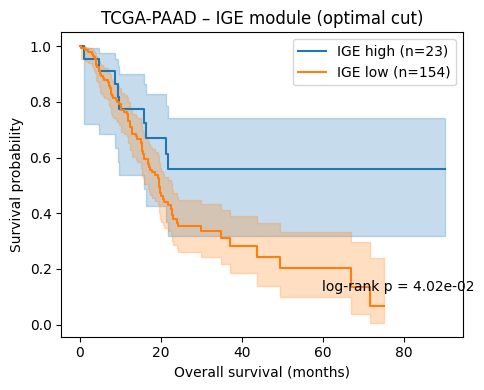

In [25]:
# Cell – Optimal cut + KM plot for IGE_signed_score (Figure 6D)

import numpy as np
import matplotlib.pyplot as plt

try:
    from lifelines import KaplanMeierFitter
    from lifelines.statistics import logrank_test
except ImportError as e:
    raise ImportError(
        "lifelines is required for this cell. Install it with:\n"
        "    pip install lifelines"
    ) from e

# 1. Drop any rows missing survival or score
km_data = df_km.dropna(subset=["os_months", "os_event", "IGE_signed_score"]).copy()
print("KM data shape after dropping NAs:", km_data.shape)

T = km_data["os_months"].astype(float)
E = km_data["os_event"].astype(int)
score = km_data["IGE_signed_score"].astype(float)

# 2. Scan candidate cutpoints & find the one with best (smallest) log-rank p-value
def find_best_cut(T, E, score, min_group_size=20, n_cuts=50):
    """
    T, E, score: 1D arrays / Series
    min_group_size: minimum n in each group for the cut to be considered
    n_cuts: number of candidate cutpoints between ~10th and 90th percentile
    """
    s = score.sort_values()
    q_low, q_high = 0.10, 0.90
    lo = s.quantile(q_low)
    hi = s.quantile(q_high)
    candidates = np.linspace(lo, hi, n_cuts)

    best_p = None
    best_cut = None

    for c in candidates:
        g_low  = score <= c
        g_high = score > c
        n_low  = g_low.sum()
        n_high = g_high.sum()

        if n_low < min_group_size or n_high < min_group_size:
            continue

        res = logrank_test(
            T[g_low], T[g_high],
            event_observed_A=E[g_low],
            event_observed_B=E[g_high]
        )

        if (best_p is None) or (res.p_value < best_p):
            best_p = res.p_value
            best_cut = c

    return best_cut, best_p

best_cut, best_p = find_best_cut(T, E, score, min_group_size=20, n_cuts=80)
print(f"Best cut on IGE_signed_score = {best_cut:.3f}, log-rank p = {best_p:.3e}")

# 3. Define groups using the optimal cut
km_data["IGE_group"] = np.where(
    km_data["IGE_signed_score"] > best_cut, "IGE_high", "IGE_low"
)

n_high = (km_data["IGE_group"] == "IGE_high").sum()
n_low  = (km_data["IGE_group"] == "IGE_low").sum()
print(f"Group sizes: IGE_high = {n_high}, IGE_low = {n_low}")

# 4. Fit KM curves
kmf_high = KaplanMeierFitter()
kmf_low  = KaplanMeierFitter()

mask_high = km_data["IGE_group"] == "IGE_high"
mask_low  = km_data["IGE_group"] == "IGE_low"

kmf_high.fit(
    durations=km_data.loc[mask_high, "os_months"],
    event_observed=km_data.loc[mask_high, "os_event"],
    label=f"IGE high (n={n_high})"
)
kmf_low.fit(
    durations=km_data.loc[mask_low, "os_months"],
    event_observed=km_data.loc[mask_low, "os_event"],
    label=f"IGE low (n={n_low})"
)

# 5. Plot – this is essentially your Figure 6D panel
plt.figure(figsize=(5, 4))
ax = plt.gca()

kmf_high.plot_survival_function(ax=ax)
kmf_low.plot_survival_function(ax=ax)

ax.set_xlabel("Overall survival (months)")
ax.set_ylabel("Survival probability")
ax.set_title("TCGA-PAAD – IGE module (optimal cut)")

# annotate p-value on the plot
ax.text(
    0.65, 0.15,
    f"log-rank p = {best_p:.2e}",
    transform=ax.transAxes,
    fontsize=10,
)

plt.tight_layout()
plt.show()


IGE-high: 23, IGE-low: 154


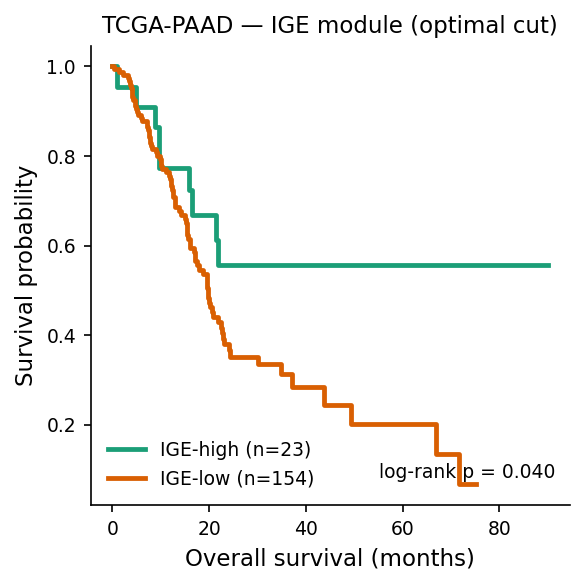

In [27]:
# Final Figure 6D KM plot – IGE signed score (High = better survival)

from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt

# --- 1. Ensure df_km and best_cut exist ---
if "df_km" not in globals():
    raise NameError("df_km not found. Make sure you ran the merge cell.")

if "best_cut" not in globals():
    raise NameError("best_cut not found. Run the optimal cut cell first.")

# --- 2. Define groups ---
mask_high = df_km["IGE_signed_score"] >= best_cut
mask_low  = ~mask_high

n_high = mask_high.sum()
n_low  = mask_low.sum()

print(f"IGE-high: {n_high}, IGE-low: {n_low}")

# --- 3. Kaplan–Meier fits ---
kmf_high = KaplanMeierFitter()
kmf_low  = KaplanMeierFitter()

kmf_high.fit(
    durations=df_km.loc[mask_high, "os_months"],
    event_observed=df_km.loc[mask_high, "os_event"],
    label=f"IGE-high (n={n_high})"
)

kmf_low.fit(
    durations=df_km.loc[mask_low, "os_months"],
    event_observed=df_km.loc[mask_low, "os_event"],
    label=f"IGE-low (n={n_low})"
)

# --- 4. Log-rank p-value ---
lr = logrank_test(
    df_km.loc[mask_high, "os_months"],
    df_km.loc[mask_low,  "os_months"],
    event_observed_A=df_km.loc[mask_high, "os_event"],
    event_observed_B=df_km.loc[mask_low,  "os_event"],
)
p_val = lr.p_value

# --- 5. Polished plotting ---
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)

color_high = "#1b9e77"   # green = better survival
color_low  = "#d95f02"   # orange = poorer survival

kmf_high.plot(ax=ax, ci_show=False, lw=2.3, color=color_high)
kmf_low.plot(ax=ax,  ci_show=False, lw=2.3, color=color_low)

ax.set_xlabel("Overall survival (months)", fontsize=11)
ax.set_ylabel("Survival probability", fontsize=11)
ax.set_title("TCGA-PAAD — IGE module (optimal cut)", fontsize=11)

# legend styling
leg = ax.legend(frameon=False, fontsize=9, loc="lower left")
for line in leg.get_lines():
    line.set_linewidth(2.3)

# annotate p-value
ax.text(
    0.97, 0.05,
    f"log-rank p = {p_val:.3f}",
    transform=ax.transAxes,
    ha="right",
    va="bottom",
    fontsize=9,
)

# cosmetics
ax.tick_params(axis="both", labelsize=9)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()


In [29]:
SAT_UP = [
    "ABHD8","AC004870.4","AC005920.1","AC009041.1","AC009309.1","AC011498.1","AC012447.1","AC018521.5",
    "AC018754.1","AC027237.2","AC068338.2","AC072061.1","AC079305.3","AC079807.1","AC087623.2","AC090403.1",
    "AC091271.1","AC092287.1","AC092910.3","AC093323.1","AC099778.1","AC107959.2","AC125611.3","AC144652.1",
    "AC239799.2","AC253572.2","ACBD7","AFMID","AHCY","AL021155.5","AL022069.1","AL031963.3","AL049869.2",
    "AL121574.1","AL133523.1","AL139106.1","AL139246.5","AL355075.4","AL360012.1","AL365436.2","AL592295.5",
    "AL662844.4","AP001160.1","AP002381.2","AP002813.1","ARL4D","ATP2B1-AS1","ATRIP","BAMBI","BHLHE40-AS1",
    "BOLA1","BUD23","C12orf65","C19orf48","C2CD4B","C6orf120","CABYR","CCDC9","CCNE2","CDKN2AIP","CHCHD7",
    "CITED2","CROCC","CSKMT","CTH","DALRD3","DRAIC","DUSP28","EAF2","EIF4A3","FOXA3","FOXL1","GADD45B","GLA",
    "GOT1","GRPEL1","GTF2A1","GTF2B","HEXIM1","HIST1H2AG","HIST1H2AH","HIST1H2AL","HIST1H2BJ","HIST1H2BN",
    "HIST1H3A","HIST1H3J","HIST1H4A","HIST1H4C","HIST1H4E","HIST2H2AC","HIST2H3PS2","HIST3H2A","HIST4H4","HMBS",
    "HSPA2","ID2","IDI1","ING1","KCTD5","KIF9","KLHL11","LAP3","LIFR-AS1","LINC01970","LINC02029","LINC02363",
    "LRG1","LRTOMT","MAFB","MED29","MEPCE","MIR17HG","MORF4L2-AS1","MTHFD2","MYCL","MYOSLID","NANOS1","NPW",
    "NRARP","OAT","OSER1-DT","OSGIN1","PHYH","PICART1","PIEZO1","PIK3R3","PLIN5","PLK2","PMAIP1","PMEL","PNKD",
    "POU3F1","PPP1R3C","PRMT5-AS1","PRR3","PTCH2","PTPN6","RAB26","RALY-AS1","RASL11A","RND1","RNF223","RUVBL2",
    "SAE1","SENP8","SIAH2-AS1","SIRT2","SLC7A5","SNHG12","SNHG5","SNHG8","SREBF2-AS1","SRSF7","STARD5","TBPL1",
    "TCTA","THAP9","TLCD1","TM7SF2","TMEM107","TMEM171","TMEM69","TNFRSF10D","TNK1","TRAM2-AS1","TTC33","UAP1",
    "UBAC2-AS1","UBE2D3-AS1","UBE2S","UGDH","WDR74","Z93241.1","Z99127.4","ZC3H10","ZCWPW1","ZFAS1","ZFX-AS1",
    "ZNF574","ZNF584","ZNF622","ZNF687-AS1","ZNF844","ZNF92","ZSWIM3"
]
SAT_DOWN = [
    "PAX5","AC117386.2","PRSS55","RPS16","GDF7","PAK4","AC022144.1","AC092745.5","AL670729.3",
    "DLEU2L","ELP3","KCNC2","MAP4K1","AL161729.4","SV2C","RGS11","AC005498.1","WFDC5","PSENEN",
    "LINC01956","AC115485.1","CYSLTR2","ASMTL-AS1","AP002001.3","FAM153B"
]
SAT_UP = [g.strip().upper() for g in SAT_UP]
SAT_DOWN = [g.strip().upper() for g in SAT_DOWN]

In [38]:
MPC_UP = [
    "KIAA1211L","CASC4","AHR","YY1AP1","COPA","RELL1","FBXW2","CARMIL1","NUBPL","ZC3H18","AGK","HLCS",
    "TMEM241","URGCP","CADPS2","COBL","ARHGAP42","AC138305.1","FAM135A","SLC41A2","TACC2","MCU","FMN1",
    "LGR4","BAIAP2L1","SGPP2","RGS12","PTPN3","IBTK","SPRY4-AS1","UGT8","PNN","SP140L","PIK3CA","CNOT2",
    "ZFC3H1","UBE2K","STRN3","STAG2","KDM5A","RC3H2","TP53BP1","SLC9A8","ATF7IP","MLLT10","SCAPER","CPSF6",
    "KLC1","HUWE1","TAOK3","ROCK1","MAN2A1","ZNF44","ARGLU1","EHMT1","HTT","SIN3A","RSBN1L","MLLT3","RABGAP1",
    "SCFD1","NEMF","DMXL1","RCOR3","NAA35","WWP1","VPS41","PRRC2B","STX16","ANKRD11","ARHGEF7","SOS2","SLAIN2",
    "LUC7L2","SRPK2","TYW1","HMBOX1","LMBR1","TCF12","MBD5","MON2","COG5","LONP2","RAB3GAP2","LARP4B","NUMB",
    "NF1","NCOA2","ZNF710","CSNK1G1","WDR37","NUTM2B-AS1","ITFG1","UBE3C","MFSD14C","SPG11","PTK2","LPP",
    "ZBTB20","FCHO2","PTPN12","DCUN1D4","KDM7A","SLMAP","KIF13B","MIB1","DIP2C","LRCH1","TNIK","TNKS","SMC5",
    "ANKIB1","RBM33","TNPO3","OSBPL3","RAPGEF2","MED13L","FBXL20","KIAA0232","ITCH","MARCH6","ARID4B","PLEKHA6",
    "FNBP1L","KIAA1217","FARP2","MAGI3","DIAPH2","VPS13A","DGKH","GNAQ","ARHGEF12","MYO1D","CDC42BPA","TTC7A",
    "TRIM44","NSD3","NCOA3","ADNP","RUFY3","RUNX1","TRRAP","PTBP2","ZNF609","CHD7","PARP8","ARIH1","ZHX2",
    "ETV6","CUL1","CDK13","BRAF","MBTD1","AUH","STX17","POLR2J3","KLHDC10","TAF1","TOGARAM1","WRN","ADK",
    "TASOR2","NUDCD3","TBL1X","MOSMO","USP42","CRCP","GALNT11","DDI2","TTC14","UPF2","PDXDC1","ETFDH","SEL1L3",
    "HEATR5A","PSMD5","TBC1D2B","NUP214","GAPVD1","RNF19A","SMURF2","NRIP1","WDFY2","TBK1","LCORL","USP25",
    "RABGEF1","CASD1","RBPJ","AEBP2","MALAT1","MAML2","RBMS1","CRIM1","SNX29","PPFIBP1","SVIL","DDX24","G2E3",
    "RASA1","FAM160A1","RNF24","ESYT2","EPS8","SESTD1","ATP2B4","PELI1","RNF145","B4GALT5","PPP2R2A","NOS1AP",
    "EGFR","CPNE8","ARHGAP21","SMAD3","DAPK1","IGF1R","AFAP1","KLF7","DOCK5","MINDY2","ZXDC","NEDD4","METTL15",
    "FNIP2","NEAT1","CELF1","DANT2","SYT17","TMEM245","ERICH1","ADPGK","LMBRD1","MFSD11","GOLGA2","SCNN1A",
    "XDH","PLEKHA1","PPP2CB","GTF2E2","KCNK1","SPATS2L","RTF1","UACA","VAV2","MDFIC","STAM","CLIP4","KYAT1",
    "MECP2","NUP160","THOC1","LINC-PINT","MCPH1","DISC1","UBA6-AS1","AAK1","NRF1","PHF20","RNF216","PCM1","SAFB2",
    "FAM133B","NR6A1","ATL2","C1orf21","MTUS1","PARD3B","EXT1","ST5","ABI2","INTS6L","TRIM56","PTER","PRR12",
    "RSPH3","TMC5","MECOM","ARHGEF10L","HNF4G","PPM1H","AP005230.1","AC119674.1","ZSCAN18","NOL4L","PDPK1",
    "RSU1","TTC39C","COL27A1","SEC16B","AC005162.3","RASAL1","IL17RA","SPART-AS1","CDC37","MUCL3","TMEM178B",
    "LINC02614","EREG","ELK3","TMTC1","PALM2-AKAP2","RAB31","EMP3"
]


MPC_DOWN = [
    "MRPS15","TALDO1","MDH2","PSMB5","PIK3CD-AS2","DUSP9","POPDC3","AKR1C3","MRPS18A","EIF3H","UQCRC2",
    "IFT22","RAB11B","MBOAT7"
]

MPC_UP = [g.strip().upper() for g in SAT_UP]
MPC_DOWN = [g.strip().upper() for g in SAT_DOWN]


In [39]:
IL2_UP = [
    "ABHD15-AS1","AC007780.1","AC008105.3","AC008964.1","AC016831.1","AC016831.5","AC090772.1","AC108863.2",
    "ADARB1","ALOX5AP","ANKH","ANKRD44","APOBEC3G","ARHGDIB","ARL6IP5","ARSG","ATP10D","BCL11B","BORCS5",
    "CAMK1D","CD4","CD84","CD96","CDC42EP3","CELF2","CERS4","CLEC2D","CNOT6L","CRYBG1","CTSW","DSE","FGD3",
    "FMNL1","FOXN3","FOXO1","FYB1","GFI1","GNAO1","GPRIN3","HOPX","IGF1","IKZF3","IL18R1","INKA2","INSYN2B",
    "IQSEC1","ITPRIPL1","JAK3","KLRC2","KLRC3","KLRF1","KLRG1","LAPTM5","LCP1","LEPROTL1","LINC00513",
    "LINC01237","MAN1A1","MAPRE2","MPHOSPH9","MPP7","MVB12B","MYO5A","NIN","PARP11","PARP15","PCED1B-AS1",
    "PDE3B","PIP4K2A","PLCL1","PLEKHA2","PPP3CC","PRKCH","PRKCQ","PRKD3","PRKX","PTPN22","RAC2","RASGRF2",
    "RFX3","RIPOR2","RNF166","S1PR4","SAMD3","SENP7","SH2B3","SH2D2A","SMARCA2","SNHG26","SPOCK2","SRGN",
    "ST8SIA1","STAT5A","STAT5B","STIM1","STK17A","TMEM200A","TMX4","TRBC2","TRDC","TRIM22","TTN","VAV3",
    "WNT5A-AS1","ZNF101","ZNF471"
]
IL2_DOWN = [
    "RBP7","OVCA2","PLAC4","AC026785.3","LINC02212","LINC00605","AC246817.2","FOXCUT","VGLL2","ZIC4","FOLR3",
    "ECEL1","AC024337.1","C5orf58","AC060814.3","B4GALNT1","UCHL1","VAX1","AL451042.1","COMMD8","IFI30",
    "AL096794.1","RGS10"
]
IL2_UP = [g.strip().upper() for g in SAT_UP]
IL2_DOWN = [g.strip().upper() for g in SAT_DOWN]


In [32]:
whos


Variable              Type                 Data/Info
----------------------------------------------------
E                     Series               0      0\n1      0\n2    <...>Length: 177, dtype: int64
IGE_DOWN              list                 n=20
IGE_UP                list                 n=118
KaplanMeierFitter     type                 <class 'lifelines.fitters<...>itter.KaplanMeierFitter'>
Path                  type                 <class 'pathlib.Path'>
SAT_DOWN              list                 n=25
SAT_UP                list                 n=185
T                     Series               0      68.514318\n1      <...>ngth: 177, dtype: float64
TCGA_EXPR             PosixPath            /Users/scottpowers/Deskto<...>normalized__data.data.txt
ax                    Axes                 Axes(0.164444,0.142361;0.798056x0.755417)
bad                   NoneType             None
best_cut              float64              -0.35155843849818846
best_cut_for_km       function           

SAT-high: 69, SAT-low: 108


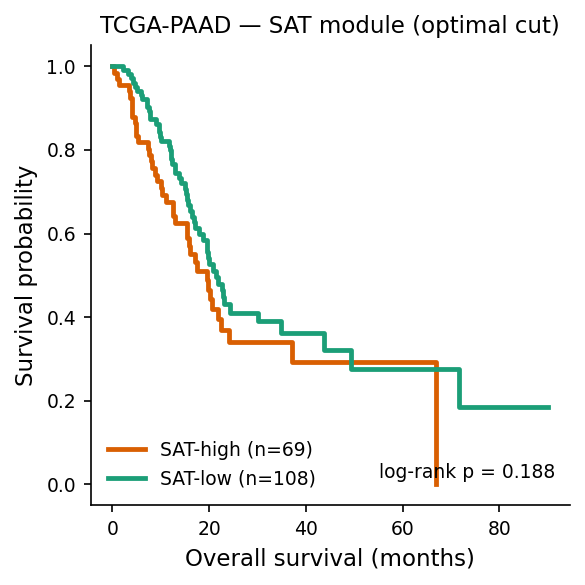

In [37]:
# Final KM plot – SAT signed score (separate from IGE)

from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt

# --- 1. Ensure SAT KM data and cutpoint exist ---
if "km_sat_df" not in globals():
    raise NameError("km_sat_df not found. Make sure you built the SAT KM table.")

if "best_cut_sat" not in globals():
    raise NameError("best_cut_sat not found. Run the SAT optimal-cut cell first.")

# --- 2. Define SAT-high / SAT-low groups ---
mask_high = km_sat_df["SAT_signed_score"] >= best_cut_sat
mask_low  = ~mask_high

n_high = int(mask_high.sum())
n_low  = int(mask_low.sum())

print(f"SAT-high: {n_high}, SAT-low: {n_low}")

# --- 3. Kaplan–Meier fits ---
kmf_high = KaplanMeierFitter()
kmf_low  = KaplanMeierFitter()

kmf_high.fit(
    durations=km_sat_df.loc[mask_high, "os_months"],
    event_observed=km_sat_df.loc[mask_high, "os_event"],
    label=f"SAT-high (n={n_high})"
)

kmf_low.fit(
    durations=km_sat_df.loc[mask_low, "os_months"],
    event_observed=km_sat_df.loc[mask_low, "os_event"],
    label=f"SAT-low (n={n_low})"
)

# --- 4. Log-rank p-value for SAT ---
lr_sat = logrank_test(
    km_sat_df.loc[mask_high, "os_months"],
    km_sat_df.loc[mask_low,  "os_months"],
    event_observed_A=km_sat_df.loc[mask_high, "os_event"],
    event_observed_B=km_sat_df.loc[mask_low,  "os_event"],
)
p_val_sat = lr_sat.p_value

# --- 5. Polished plotting (parallel to IGE aesthetics) ---
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)

# If SAT-high is "worse", you might want high = orange, low = green:
color_high = "#d95f02"   # SAT-high
color_low  = "#1b9e77"   # SAT-low

kmf_high.plot(ax=ax, ci_show=False, lw=2.3, color=color_high)
kmf_low.plot(ax=ax,  ci_show=False, lw=2.3, color=color_low)

ax.set_xlabel("Overall survival (months)", fontsize=11)
ax.set_ylabel("Survival probability", fontsize=11)
ax.set_title("TCGA-PAAD — SAT module (optimal cut)", fontsize=11)

# legend styling
leg = ax.legend(frameon=False, fontsize=9, loc="lower left")
for line in leg.get_lines():
    line.set_linewidth(2.3)

# annotate p-value
ax.text(
    0.97, 0.05,
    f"log-rank p = {p_val_sat:.3f}",
    transform=ax.transAxes,
    ha="right",
    va="bottom",
    fontsize=9,
)

# cosmetics
ax.tick_params(axis="both", labelsize=9)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()


SAT-high: 69, SAT-low: 108


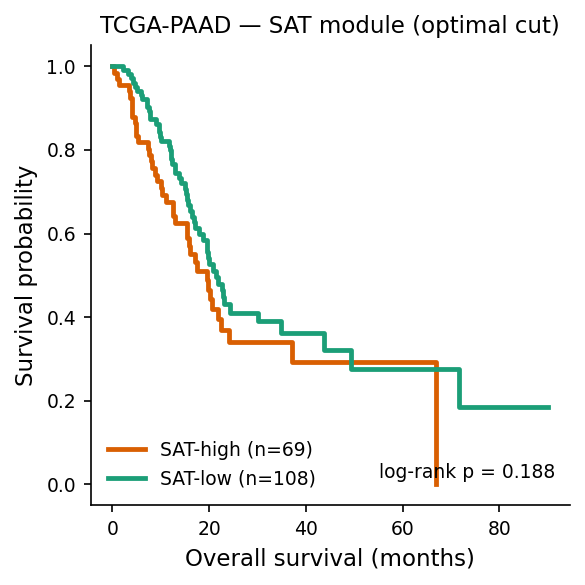

In [41]:
# Final KM plot – MPC signed score (separate from IGE)

from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt

# --- 1. Ensure SAT KM data and cutpoint exist ---
if "km_sat_df" not in globals():
    raise NameError("km_sat_df not found. Make sure you built the SAT KM table.")

if "best_cut_sat" not in globals():
    raise NameError("best_cut_sat not found. Run the SAT optimal-cut cell first.")

# --- 2. Define SAT-high / SAT-low groups ---
mask_high = km_sat_df["SAT_signed_score"] >= best_cut_sat
mask_low  = ~mask_high

n_high = int(mask_high.sum())
n_low  = int(mask_low.sum())

print(f"SAT-high: {n_high}, SAT-low: {n_low}")

# --- 3. Kaplan–Meier fits ---
kmf_high = KaplanMeierFitter()
kmf_low  = KaplanMeierFitter()

kmf_high.fit(
    durations=km_sat_df.loc[mask_high, "os_months"],
    event_observed=km_sat_df.loc[mask_high, "os_event"],
    label=f"SAT-high (n={n_high})"
)

kmf_low.fit(
    durations=km_sat_df.loc[mask_low, "os_months"],
    event_observed=km_sat_df.loc[mask_low, "os_event"],
    label=f"SAT-low (n={n_low})"
)

# --- 4. Log-rank p-value for SAT ---
lr_sat = logrank_test(
    km_sat_df.loc[mask_high, "os_months"],
    km_sat_df.loc[mask_low,  "os_months"],
    event_observed_A=km_sat_df.loc[mask_high, "os_event"],
    event_observed_B=km_sat_df.loc[mask_low,  "os_event"],
)
p_val_sat = lr_sat.p_value

# --- 5. Polished plotting (parallel to IGE aesthetics) ---
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)

# If SAT-high is "worse", you might want high = orange, low = green:
color_high = "#d95f02"   # SAT-high
color_low  = "#1b9e77"   # SAT-low

kmf_high.plot(ax=ax, ci_show=False, lw=2.3, color=color_high)
kmf_low.plot(ax=ax,  ci_show=False, lw=2.3, color=color_low)

ax.set_xlabel("Overall survival (months)", fontsize=11)
ax.set_ylabel("Survival probability", fontsize=11)
ax.set_title("TCGA-PAAD — SAT module (optimal cut)", fontsize=11)

# legend styling
leg = ax.legend(frameon=False, fontsize=9, loc="lower left")
for line in leg.get_lines():
    line.set_linewidth(2.3)

# annotate p-value
ax.text(
    0.97, 0.05,
    f"log-rank p = {p_val_sat:.3f}",
    transform=ax.transAxes,
    ha="right",
    va="bottom",
    fontsize=9,
)

# cosmetics
ax.tick_params(axis="both", labelsize=9)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()


MPC cutpoint used = 0.029 (median cut (best_cut_mpc was None))
MPC-high: 89, MPC-low: 88
log-rank p (MPC): 0.8937


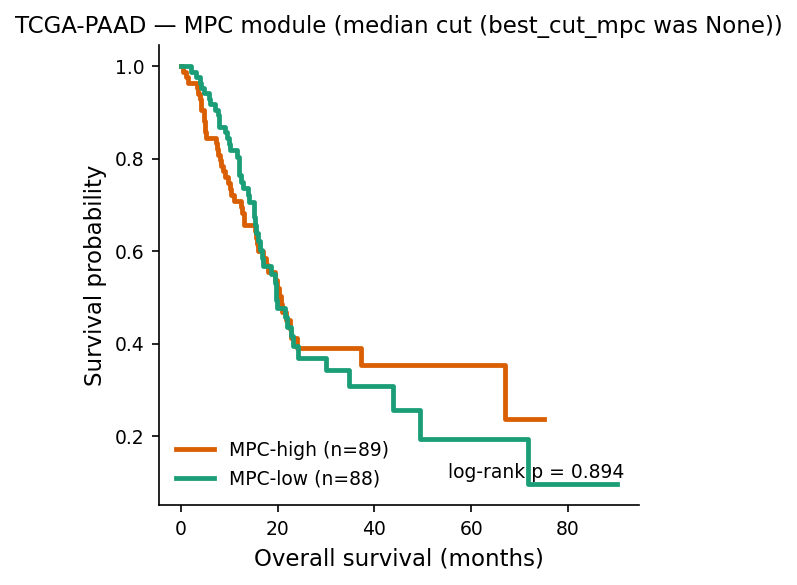

In [44]:
# Final Figure 6D-style KM plot – MPC signed score
# High MPC = worse survival (orange), Low MPC = better survival (green)

from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt

# --- 1. Sanity checks ---
if "km_mpc_df" not in globals():
    raise NameError("km_mpc_df not found. Make sure you built the MPC KM dataframe.")

if "MPC_signed_score" not in km_mpc_df.columns:
    raise KeyError("km_mpc_df must contain a 'MPC_signed_score' column.")

# --- 2. Choose cutpoint: use optimal cut if available, else median ---
if "best_cut_mpc" in globals() and best_cut_mpc is not None:
    cut_mpc = float(best_cut_mpc)
    cut_label = "optimal cut"
else:
    cut_mpc = km_mpc_df["MPC_signed_score"].median()
    cut_label = "median cut (best_cut_mpc was None)"

print(f"MPC cutpoint used = {cut_mpc:.3f} ({cut_label})")

# --- 3. Define groups (MPC-high = worse survival, MPC-low = better) ---
mask_high_mpc = km_mpc_df["MPC_signed_score"] >= cut_mpc
mask_low_mpc  = ~mask_high_mpc

n_high_mpc = int(mask_high_mpc.sum())
n_low_mpc  = int(mask_low_mpc.sum())

print(f"MPC-high: {n_high_mpc}, MPC-low: {n_low_mpc}")

# --- 4. Kaplan–Meier fits ---
kmf_high_mpc = KaplanMeierFitter()
kmf_low_mpc  = KaplanMeierFitter()

kmf_high_mpc.fit(
    durations=km_mpc_df.loc[mask_high_mpc, "os_months"],
    event_observed=km_mpc_df.loc[mask_high_mpc, "os_event"],
    label=f"MPC-high (n={n_high_mpc})"
)

kmf_low_mpc.fit(
    durations=km_mpc_df.loc[mask_low_mpc, "os_months"],
    event_observed=km_mpc_df.loc[mask_low_mpc, "os_event"],
    label=f"MPC-low (n={n_low_mpc})"
)

# --- 5. Log-rank test ---
lr_mpc = logrank_test(
    km_mpc_df.loc[mask_high_mpc, "os_months"],
    km_mpc_df.loc[mask_low_mpc,  "os_months"],
    event_observed_A=km_mpc_df.loc[mask_high_mpc, "os_event"],
    event_observed_B=km_mpc_df.loc[mask_low_mpc,  "os_event"],
)
p_val_mpc = lr_mpc.p_value
print(f"log-rank p (MPC): {p_val_mpc:.4f}")

# --- 6. Polished plotting ---
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)

# Here: orange = worse (MPC-high), green = better (MPC-low)
color_high = "#d95f02"   # MPC-high (worse survival)
color_low  = "#1b9e77"   # MPC-low (better survival)

kmf_high_mpc.plot(ax=ax, ci_show=False, lw=2.3, color=color_high)
kmf_low_mpc.plot(ax=ax,  ci_show=False, lw=2.3, color=color_low)

ax.set_xlabel("Overall survival (months)", fontsize=11)
ax.set_ylabel("Survival probability", fontsize=11)
ax.set_title(f"TCGA-PAAD — MPC module ({cut_label})", fontsize=11)

# legend styling
leg = ax.legend(frameon=False, fontsize=9, loc="lower left")
for line in leg.get_lines():
    line.set_linewidth(2.3)

# annotate p-value
ax.text(
    0.97, 0.05,
    f"log-rank p = {p_val_mpc:.3f}",
    transform=ax.transAxes,
    ha="right",
    va="bottom",
    fontsize=9,
)

# cosmetics
ax.tick_params(axis="both", labelsize=9)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()


In [45]:
# === MPC module KM analysis — median cut, using z-scored gene expression ===
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 0. Sanity checks
required_vars = ["expr_for_scoring", "df_surv", "MPC_UP", "MPC_DOWN", "score_signed_module"]
for v in required_vars:
    if v not in globals():
        raise NameError(f"Variable '{v}' is not defined. Make sure the earlier cells for TCGA, "
                        f"survival, and MPC_UP/MPC_DOWN lists have been run.")

# 1. Compute MPC signed module score (this function already z-scores genes across samples)
mpc_score_tcga, cov_mpc = score_signed_module(
    expr=expr_for_scoring,   # same matrix used for IGE
    up_genes=MPC_UP,
    down_genes=MPC_DOWN,
    min_genes=10,
)

print("MPC module coverage:")
print(f"  up   used/total: {cov_mpc['up_used']} / {cov_mpc['up_total']}")
print(f"  down used/total: {cov_mpc['down_used']} / {cov_mpc['down_total']}\n")

# 2. Build a score table that maps full barcodes to TCGA sample IDs
mpc_scores_df = (
    pd.DataFrame({
        "full_barcode": expr_for_scoring.columns,
        "MPC_signed_score": mpc_score_tcga.values,
    })
    # TCGA sampleId is the first 12 chars (same as for IGE)
    .assign(sampleId=lambda d: d["full_barcode"].str.slice(0, 12))
)

print("MPC score table:")
display(mpc_scores_df.head())

# 3. Merge with survival data (df_surv already has os_months/os_event)
km_mpc_df = (
    pd.merge(
        df_surv[["sampleId", "os_months", "os_event"]],
        mpc_scores_df[["sampleId", "MPC_signed_score"]],
        on="sampleId",
        how="inner",
    )
    .dropna(subset=["os_months", "os_event", "MPC_signed_score"])
)

print(f"\nKM rows for MPC: {km_mpc_df.shape}")
display(km_mpc_df.head())

# 4. (Optional) z-score the MPC module score across patients
#    This doesn't change the KM p-value (monotonic transform),
#    but makes the scale comparable and matches your intuition about "using z-scores".
km_mpc_df["MPC_z"] = (
    km_mpc_df["MPC_signed_score"] - km_mpc_df["MPC_signed_score"].mean()
) / (km_mpc_df["MPC_signed_score"].std(ddof=0) + 1e-9)

# 5. Define high / low groups using MEDIAN cut on MPC_z
median_cut_mpc = km_mpc_df["MPC_z"].median()
print(f"\nMPC median cut (on z-scored module): {median_cut_mpc:.3f}")

mask_high_mpc = km_mpc_df["MPC_z"] >= median_cut_mpc
mask_low_mpc  = ~mask_high_mpc

n_high_mpc = int(mask_high_mpc.sum())
n_low_mpc  = int(mask_low_mpc.sum())
print(f"Group sizes: MPC-high = {n_high_mpc}, MPC-low = {n_low_mpc}")

# 6. KM fits
kmf_high_mpc = KaplanMeierFitter()
kmf_low_mpc  = KaplanMeierFitter()

kmf_high_mpc.fit(
    durations=km_mpc_df.loc[mask_high_mpc, "os_months"],
    event_observed=km_mpc_df.loc[mask_high_mpc, "os_event"],
    label=f"MPC-high (n={n_high_mpc})"
)

kmf_low_mpc.fit(
    durations=km_mpc_df.loc[mask_low_mpc, "os_months"],
    event_observed=km_mpc_df.loc[mask_low_mpc, "os_event"],
    label=f"MPC-low (n={n_low_mpc})"
)

# 7. Log-rank test
lr_mpc = logrank_test(
    km_mpc_df.loc[mask_high_mpc, "os_months"],
    km_mpc_df.loc[mask_low_mpc,  "os_months"],
    event_observed_A=km_mpc_df.loc[mask_high_mpc, "os_event"],
    event_observed_B=km_mpc_df.loc[mask_low_mpc,  "os_event"],
)
p_val_mpc = lr_mpc.p_value
print(f"\nMPC log-rank p = {p_val_mpc:.3f}")

# 8. Polished KM plot for MPC
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)

# MPC-high = worse survival (orange), MPC-low = better (green)
color_high = "#d95f02"   # high = adverse, orange
color_low  = "#1b9e77"   # low  = better, green

kmf_high_mpc.plot(ax=ax, ci_show=False, lw=2.3, color=color_high)
kmf_low_mpc.plot(ax=ax,  ci_show=False, lw=2.3, color=color_low)

ax.set_xlabel("Overall survival (months)", fontsize=11)
ax.set_ylabel("Survival probability", fontsize=11)
ax.set_title("TCGA-PAAD — MPC module (median cut)", fontsize=11)

# legend styling
leg = ax.legend(frameon=False, fontsize=9, loc="lower left")
for line in leg.get_lines():
    line.set_linewidth(2.3)

# annotate p-value
ax.text(
    0.97, 0.05,
    f"log-rank p = {p_val_mpc:.3f}",
    transform=ax.transAxes,
    ha="right",
    va="bottom",
    fontsize=9,
)

# cosmetics
ax.tick_params(axis="both", labelsize=9)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()


MPC module coverage:
  up   used/total: 110 / 185
  down used/total: 15 / 25

MPC score table:


,full_barcode,MPC_signed_score,sampleId
0,TCGA-2J-AAB1-01A-11R-A41B-07,-0.228062,TCGA-2J-AAB1
1,TCGA-2J-AAB4-01A-12R-A41B-07,-0.397924,TCGA-2J-AAB4
2,TCGA-2J-AAB6-01A-11R-A41B-07,0.068761,TCGA-2J-AAB6
3,TCGA-2J-AAB8-01A-12R-A41B-07,0.103592,TCGA-2J-AAB8
4,TCGA-2J-AAB9-01A-11R-A41B-07,0.149592,TCGA-2J-AAB9



KM rows for MPC: (0, 4)


,sampleId,os_months,os_event,MPC_signed_score



MPC median cut (on z-scored module): nan
Group sizes: MPC-high = 0, MPC-low = 0


ValueError: Values must be numeric: no strings, datetimes, objects, etc.